K-Means


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

print("Libraries loaded successfully.")




Libraries loaded successfully.


K-Means Algorithm Implementation

In [3]:
#Assigns each data point to the closest centroid.
def find_closest_centroids(points, centroids):
    num_points = points.shape[0]
    num_centroids = centroids.shape[0]
    assignments = np.zeros(num_points, dtype=int)

    for point_index in range(num_points):
        #Calculate distance from point X[i] to all centroids as we have done in the exercises by hand
        distances = np.sum((points[point_index] - centroids) ** 2, axis=1)
        #Assign to the index of the minimum distance
        assignments[point_index] = np.argmin(distances)
    
    return assignments

#Returns new centroids by averaging points assigned to each cluster.
def compute_centroids(points, assignments, num_centroids):
    num_points, num_features = points.shape       
    new_centroids = np.zeros((num_centroids, num_features))
    for centroid_index in range(num_centroids):   
        #Points assigned to this centroid
        cluster_points = points[assignments == centroid_index]
        if len(cluster_points) > 0:
            new_centroids[centroid_index] = np.mean(cluster_points, axis=0)
    
    return new_centroids


print("Testing manual implementation with random data...")

#Generate 10 random 2D points
points_example = np.random.rand(10, 2) * 10     

#Initialize 2 random centroids
initial_centroids = points_example[:2]

#Run one iteration
print("Initial Centroids:\n", initial_centroids)

assignments_example = find_closest_centroids(points_example, initial_centroids)
updated_centroids = compute_centroids(points_example, assignments_example, 2)

print("New Centroids after 1 iteration:\n", updated_centroids)



Testing manual implementation with random data...
Initial Centroids:
 [[8.39069869 0.1951541 ]
 [6.98024834 1.70311147]]
New Centroids after 1 iteration:
 [[8.39069869 0.1951541 ]
 [4.43477886 4.23084156]]


Data Loading & Cleaning

In [24]:
df = pd.read_csv('./data/movies_dataset.csv')

#Feature selection
#Based on correlation analysis, we remove redundant financial columns
#We also ignore ID and ReleaseYear for the mathematical clustering
features_to_use = [
    'BudgetUSD', 
    'Global_BoxOfficeUSD', 
    'NumVotesIMDb', 
    'NumVotesRT',
    'IMDbRating', 
    'RottenTomatoesScore'
]

X = df[features_to_use]

#PREPROCESSING (Scaling y log-transform)
#We apply a log-transform to prevent very high values from dominating
for col in ['BudgetUSD', 'Global_BoxOfficeUSD', 'NumVotesIMDb', 'NumVotesRT']:
    X[col] = np.log1p(X[col])

#Critical: We must scale data because Budget is in millions and Rating is 0-10.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=features_to_use)

print("Data Preprocessing Complete.")
print(f"Features used for clustering: {features_to_use}")
print(f"Shape of training data: {X_scaled_df.shape}")

#We take a sample due to the massive number of rows
frac = 0.2
sample_indices = np.random.choice(X_scaled_df.index, size=int(frac * len(X_scaled_df)), replace=False)
X_sample_scaled_df = X_scaled_df.loc[sample_indices]
df_sample = df.loc[sample_indices]

print(f"Shape of sample data: {X_sample_scaled_df.shape}")

X_sample_scaled_df.head()

C:\Users\jon.palacios\AppData\Local\Temp\ipykernel_24464\3298266864.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = np.log1p(X[col])


Data Preprocessing Complete.
Features used for clustering: ['BudgetUSD', 'Global_BoxOfficeUSD', 'NumVotesIMDb', 'NumVotesRT', 'IMDbRating', 'RottenTomatoesScore']
Shape of training data: (999999, 6)
Shape of sample data: (199999, 6)


,BudgetUSD,Global_BoxOfficeUSD,NumVotesIMDb,NumVotesRT,IMDbRating,RottenTomatoesScore
911559,1.116555,1.370600,0.352392,-0.620125,-0.063804,0.865346
791532,0.092824,0.259636,1.877364,-0.279232,-0.131117,-0.271504
910002,-0.853963,-1.133636,0.564643,-0.468896,-0.265742,0.751661
186474,0.959450,1.233096,-0.771263,-1.357419,-0.669618,-0.669402
825623,1.100172,0.971938,1.263387,0.004248,0.878572,0.353764


Elbow Method

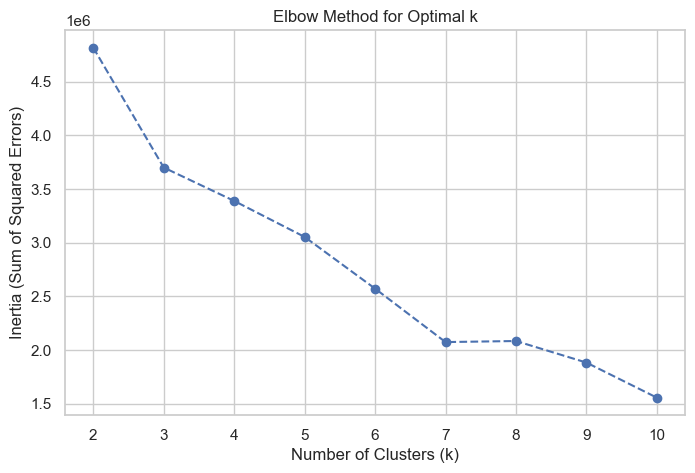

In [ ]:
inertia = []
k_range = range(2, 11) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Errors)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

DBSCAN

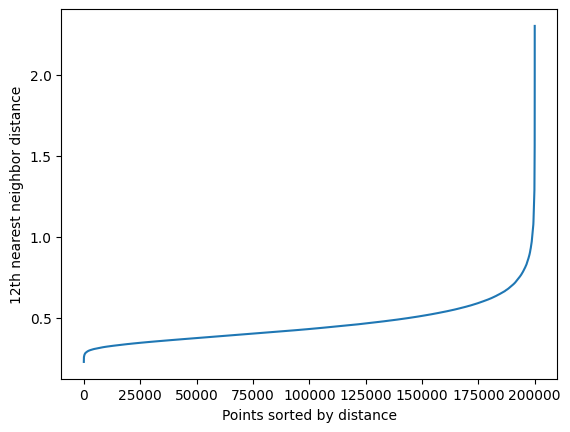

In [25]:
#We plot knn to try to choose an apropriate value for epsilon
neighbors = NearestNeighbors(n_neighbors=12)
neighbors_fit = neighbors.fit(X_sample_scaled_df)
distances, indices = neighbors_fit.kneighbors(X_sample_scaled_df)
distances = np.sort(distances[:, 11])
plt.plot(distances)
plt.ylabel("12th nearest neighbor distance")
plt.xlabel("Points sorted by distance")
plt.show()

In [26]:
clusterer = DBSCAN(eps=0.7, min_samples=12, metric='euclidean')
y_pred = clusterer.fit_predict(X_sample_scaled_df)

In [27]:
# Number of clusters and noise
unique_labels = np.unique(y_pred)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = list(y_pred).count(-1)  # O np.sum(y_pred == -1)

print(f"Número de clústers: {n_clusters}")
print(f"Número de puntos de ruido: {n_noise}")
print(f"Etiquetas únicas de clústers: {unique_labels[unique_labels != -1]}")  # Excluye -1

# We asign clusters in the DataFrame to see the details
df_sample['Cluster'] = y_pred
print("\nTamaños de cada clúster (incluyendo ruido como -1):")
print(df_sample.groupby('Cluster').size())

# Example: first 10 movies in each cluster
for cluster_id in unique_labels:
    if cluster_id != -1:
        print(f"\nClúster {cluster_id}:")
        print(df_sample[df_sample['Cluster'] == cluster_id][['Title', 'Genre', 'IMDbRating']].head(10))

Número de clústers: 1
Número de puntos de ruido: 3000
Etiquetas únicas de clústers: [0]

Tamaños de cada clúster (incluyendo ruido como -1):
Cluster
-1      3000
 0    196999
dtype: int64

Clúster 0:
                                   Title        Genre  IMDbRating
911559  Environment view participant day       Comedy         6.4
791532                   Behind need him       Horror         6.3
910002                       Who mention        Drama         6.1
186474              Return address space     Thriller         5.5
825623                         Maybe now        Drama         7.8
810888                        Back month       Comedy         6.4
925961              Generation situation      Romance         5.6
819975                    Against matter  Documentary         6.8
726540                Type happy meeting       Horror         5.9
479602                Still hold success       Comedy         8.6


Literalmente una nube 💀💀💀💀💀💀

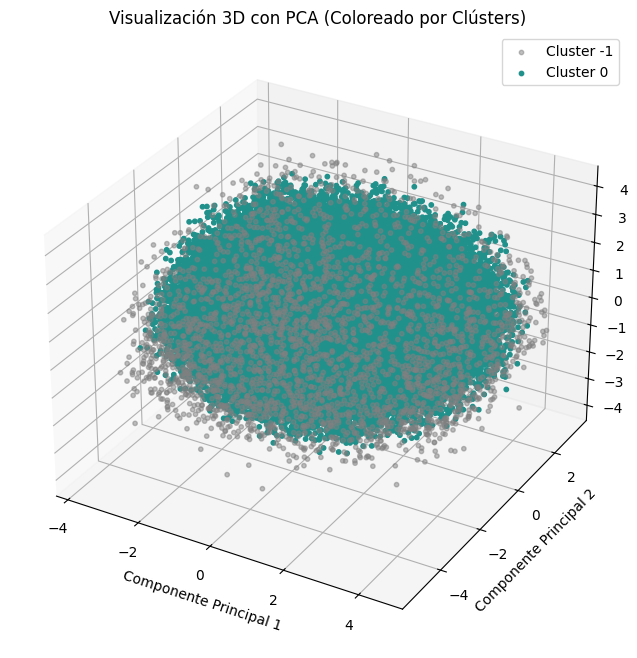

Varianza explicada por 3 componentes: 0.80


In [29]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Asumiendo X_sample_scaled_df (datos escalados) y y_pred (etiquetas)
# Cambia a X_full_scaled_df y y_pred_full si usas el dataset completo

# Aplicar PCA a 3 componentes
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_sample_scaled_df)

# Crear figura 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Colores: ruido en gris, clústers en colormap
unique_labels = np.unique(y_pred)
colors = ['gray' if label == -1 else plt.cm.viridis(i / len(unique_labels)) for i, label in enumerate(unique_labels)]

for label, color in zip(unique_labels, colors):
    mask = y_pred == label
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2], 
               c=[color], label=f'Cluster {label}', s=10, alpha=0.5 if label == -1 else 1.0)

ax.set_title('Visualización 3D con PCA (Coloreado por Clústers)')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
ax.legend()
ax.grid(True)
plt.show()

# Varianza explicada
print(f"Varianza explicada por 3 componentes: {sum(pca.explained_variance_ratio_):.2f}")